## **abalone.csv DL Regression**

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from torchsummary import summary

In [12]:
import pandas as pd
import os

# 데이터 불러오기
file_name = 'abalone.csv'
full_file_path = os.path.join(os.getcwd() + "\\" + file_name)
df = pd.read_csv(full_file_path)
df.head()

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [13]:
# 결측치 확인
df.isna().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder

# 인코딩 작업
def encode_features(dataDF) :
    features = ['Sex']
    for feature in features :
        le = LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])

    return dataDF

df = encode_features(df)
df.head()

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [15]:
from sklearn.preprocessing import StandardScaler

# 피처, 레이블 데이터
X = df.drop('Rings', axis = 1).values
y = df['Rings'].values

# 데이터 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [16]:
X

array([[-1.73163619,  1.15198011, -0.57455813, ..., -0.60768536,
        -0.72621157, -0.63821689],
       [-1.73080687,  1.15198011, -1.44898585, ..., -1.17090984,
        -1.20522124, -1.21298732],
       [-1.72997754, -1.28068972,  0.05003309, ..., -0.4634999 ,
        -0.35668983, -0.20713907],
       ...,
       [ 1.72997754,  1.15198011,  0.6329849 , ...,  0.74855917,
         0.97541324,  0.49695471],
       [ 1.73080687, -1.28068972,  0.84118198, ...,  0.77334105,
         0.73362741,  0.41073914],
       [ 1.73163619,  1.15198011,  1.54905203, ...,  2.64099341,
         1.78744868,  1.84048058]])

In [17]:
y

array([15,  7,  9, ...,  9, 10, 12], dtype=int64)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3341, 9), (836, 9), (3341,), (836,))

In [19]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

In [20]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3341, 9]),
 torch.Size([836, 9]),
 torch.Size([3341]),
 torch.Size([836]))

In [22]:
# 모델 정의
class abaloneRegression(nn.Module):
    def __init__(self):
        super(abaloneRegression, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 모델 생성
model = abaloneRegression()

In [23]:
# 손실 함수 및 최적화 기법 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

In [24]:
# 모델 훈련
# 손실 저장 리스트
train_losses = []
test_losses = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0  

    # 훈련 데이터셋 손실 계산
    for inputs, labels in train_dataloader:
        inputs = inputs.float()
        labels = labels.float()  

        optimizer.zero_grad()

        outputs = model(inputs)  
        loss = criterion(outputs.squeeze(1), labels)  

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 평균 훈련 손실 저장
    epoch_train_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_train_loss)

    # 테스트 데이터셋 손실 계산
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.float()
            labels = labels.float()  

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(1), labels)  

            test_loss += loss.item()

    # 평균 테스트 손실 저장
    epoch_test_loss = test_loss / len(test_dataloader)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")


Epoch 1/20, Train Loss: 89.4939, Test Loss: 58.3616
Epoch 2/20, Train Loss: 30.9536, Test Loss: 19.5910
Epoch 3/20, Train Loss: 15.3876, Test Loss: 11.1719
Epoch 4/20, Train Loss: 9.8458, Test Loss: 7.3198
Epoch 5/20, Train Loss: 7.4607, Test Loss: 5.9872
Epoch 6/20, Train Loss: 6.5589, Test Loss: 5.5794
Epoch 7/20, Train Loss: 6.1329, Test Loss: 5.3872
Epoch 8/20, Train Loss: 5.9071, Test Loss: 5.2563
Epoch 9/20, Train Loss: 5.6879, Test Loss: 5.2525
Epoch 10/20, Train Loss: 5.5423, Test Loss: 5.1545
Epoch 11/20, Train Loss: 5.3682, Test Loss: 5.1132
Epoch 12/20, Train Loss: 5.2492, Test Loss: 5.0879
Epoch 13/20, Train Loss: 5.1826, Test Loss: 5.0989
Epoch 14/20, Train Loss: 5.0517, Test Loss: 5.0018
Epoch 15/20, Train Loss: 4.9502, Test Loss: 5.0015
Epoch 16/20, Train Loss: 4.8768, Test Loss: 4.9647
Epoch 17/20, Train Loss: 4.8548, Test Loss: 4.9033
Epoch 18/20, Train Loss: 4.8136, Test Loss: 4.9258
Epoch 19/20, Train Loss: 4.7270, Test Loss: 4.9018
Epoch 20/20, Train Loss: 4.6807, T

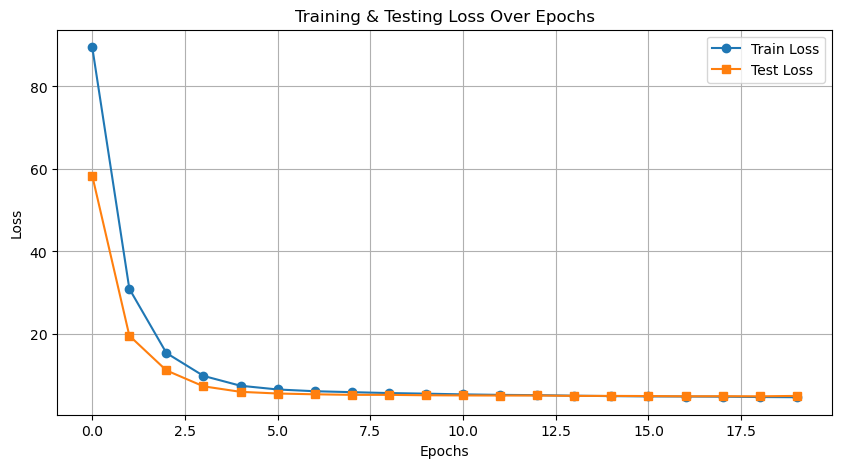

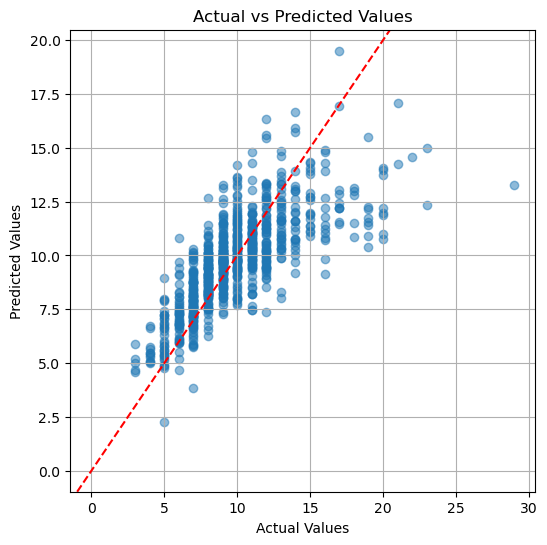

In [25]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
plt.figure(figsize = (10, 5))
plt.plot(train_losses, label = "Train Loss", marker = "o")
plt.plot(test_losses, label = "Test Loss", marker = "s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Testing Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# 실제값 vs 예측값 비교
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.float()
        labels = labels.float()

        outputs = model(inputs).squeeze(1)  
        y_pred.extend(outputs.numpy())  
        y_true.extend(labels.numpy())  

# 산점도로 실제값 vs 예측값 시각화
plt.figure(figsize = (6, 6))
plt.scatter(y_true, y_pred, alpha = 0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.axline([0, 0], [1, 1], color = "red", linestyle = "--")
plt.grid()
plt.show()


In [26]:
# MSE 계산
mse = torch.nn.functional.mse_loss(torch.tensor(y_pred), torch.tensor(y_true))
print(f"Mean Squared Error (MSE): {mse.item():.4f}")

Mean Squared Error (MSE): 4.9480


In [27]:
# MAE 계산
mae = torch.nn.functional.l1_loss(torch.tensor(y_pred), torch.tensor(y_true))
print(f"Mean Absolute Error (MAE): {mae.item():.4f}")

Mean Absolute Error (MAE): 1.5649
